Partie 1

In [70]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import csv
import folium
import folium.plugins

%matplotlib inline


In [71]:
transport_nodes = pd.read_csv('transport-nodes.csv')
print(transport_nodes.to_string())

                  id   latitude  longitude  population
0          Amsterdam  52.379189   4.899431      821752
1            Utrecht  52.092876   5.104480      334176
2           Den Haag  52.078663   4.288788      514861
3          Immingham  53.612390  -0.222190        9642
4          Doncaster  53.522850  -1.131160      302400
5   Hoek van Holland  51.977500   4.133330        9382
6         Felixstowe  51.963750   1.351100       23689
7            Ipswich  52.059170   1.155450      133384
8         Colchester  51.889210   0.904210      104390
9             London  51.509865  -0.118092     8787892
10         Rotterdam  51.922500   4.479170      623652
11             Gouda  52.016670   4.708330       70939


In [72]:
transport_relationships = pd.read_csv('transport-relationships.csv')
print(transport_relationships.to_string())

                 src               dst relationship  cost
0          Amsterdam           Utrecht        EROAD    46
1          Amsterdam          Den Haag        EROAD    59
2           Den Haag         Rotterdam        EROAD    26
3          Amsterdam         Immingham        EROAD   369
4          Immingham         Doncaster        EROAD    74
5          Doncaster            London        EROAD   277
6   Hoek van Holland          Den Haag        EROAD    27
7         Felixstowe  Hoek van Holland        EROAD   207
8            Ipswich        Felixstowe        EROAD    22
9         Colchester           Ipswich        EROAD    32
10            London        Colchester        EROAD   106
11             Gouda         Rotterdam        EROAD    25
12             Gouda           Utrecht        EROAD    35
13          Den Haag             Gouda        EROAD    32
14  Hoek van Holland         Rotterdam        EROAD    33


{'Amsterdam': {},
 'Utrecht': {},
 'Den Haag': {},
 'Rotterdam': {},
 'Immingham': {},
 'Doncaster': {},
 'London': {},
 'Hoek van Holland': {},
 'Felixstowe': {},
 'Ipswich': {},
 'Colchester': {},
 'Gouda': {}}

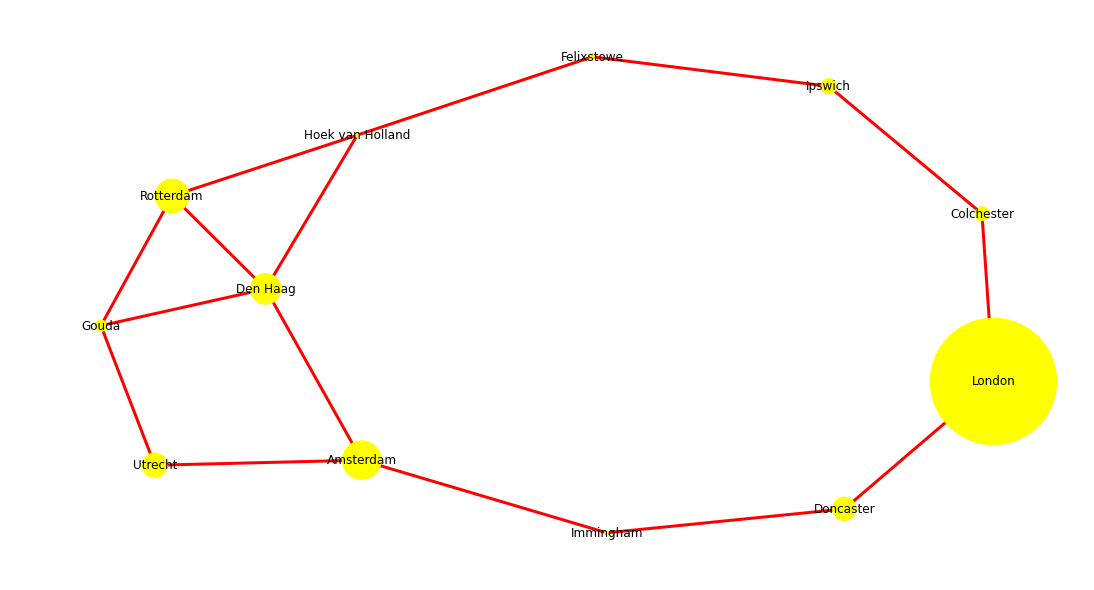

In [96]:

relationships = transport_relationships[['src', 'dst']]
population_list = []
G = nx.Graph()
G = nx.from_pandas_edgelist(relationships, 'src', 'dst')

for n in G.nodes:
    i = 0
    while(i != len(transport_nodes.id)):
        if n == transport_nodes.id[i]:
            population_list.append(transport_nodes.population[i]/550)
        i += 1

plt.figure(figsize=(15, 8))
nx.draw(G, with_labels=True, edge_color='red', width=3, node_color='yellow', node_size=population_list)
dict(G.nodes.data())


In [75]:
def ajouterAttribut(myGraphe, dfnode, nameAttr, Index):
    nodes = dfnode[[Index, nameAttr]]
    node_attr = nodes.set_index(Index).to_dict('index')
    nx.set_node_attributes(myGraphe, node_attr)

In [76]:
ajouterAttribut(G, transport_nodes, 'latitude', 'id')
ajouterAttribut(G, transport_nodes, 'longitude', 'id')
ajouterAttribut(G, transport_nodes, 'population', 'id')

In [77]:
# dict(G.nodes.data())

In [78]:

basemap = folium.Map(location=[52.3791890, 4.899431], zoom_start=5, tiles='Stamen Toner')


In [79]:
# basemap

In [80]:
def marker(g):
    for i in g.nodes:
        nodes = dict(G.nodes.data())
        latitude = nodes[i]['latitude']
        longitude = nodes[i]['longitude']
        folium.Marker(
            location=[latitude, longitude],
            icon = folium.plugins.BeautifyIcon(background_color='black', text_color='white', icon='info')
        ).add_to(basemap)
    return basemap

In [81]:
# marker(G)

In [82]:
def construirePointsImage(myGraphe):
    points = []
    nodes = dict(G.nodes.data())
    
    for i in myGraphe.nodes:
        cordonnees_node = []
        node_latitude = nodes[i]['latitude']
        node_longitude = nodes[i]['longitude']
        cordonnees_node.append(node_latitude)
        cordonnees_node.append(node_longitude)

        for neighbor in myGraphe.neighbors(i):
            cordonnees_neighbor = []
            neighbor_latitude = nodes[neighbor]['latitude']
            neighbor_longitude = nodes[neighbor]['longitude']
            cordonnees_neighbor.append(neighbor_latitude)
            cordonnees_neighbor.append(neighbor_longitude)
            
            list_neighbors = []
            list_neighbors.append(cordonnees_node)
            list_neighbors.append(cordonnees_neighbor)

            points.append(list_neighbors)

    return points

In [83]:
coordonneesvoisins = construirePointsImage(G)
# print(coordonneesvoisins)

In [84]:
def visualiserFolium(myGraphe, points, locationpardefaut=[52.3791890, 4.899431], tiles='Stamen Toner', explored=None ):
    basemap = folium.Map(location=locationpardefaut, zoom_start=5, tiles=tiles, explored=explored)
    points = construirePointsImage(myGraphe)
    folium.PolyLine(points, color="yellow", weight=3).add_to(basemap)
    return basemap

In [85]:
# visualiserFolium(G, coordonneesvoisins)

Partie 2

In [86]:
class Noeud:
	
	def __init__(self, name):
		self.name = name
		'''
			Un noeud a des attributs sous forme de dictionnaire pyton avec comme cle: une liste de 
			coordonnes (latitude, longitude), la taille de la population
		'''
		self.attributs = {}
		'''
			La liste des voisins sera initialisée à la création des arcs dans le graphe
		'''
		self.listeNomVoisin = []

	def setAttribut(self, key, values):
		self.attributs.update({key:values})

	def getAttribut(self, key):		
		if key not in self.attributs:
			return "Clé inexistante"
		else:
			return key + " = " + str(self.attributs[key])

	def getName(self):
		return self.name

	'''
	Deux noeuds sont égaux s'ils ont même nom
	'''
	def egal(self, noeud):
		if(self.name == noeud.name):
			return True
		else:
			return False
	
	def getCoutMin(self):
		noeuds = transport_relationships[['src', 'dst', 'cost']].to_dict('index')
		cout = 500
		for noeud in noeuds:
			if(noeuds[noeud]['src'] == self.name and noeuds[noeud]['cost'] < cout):
				cout = noeuds[noeud]['cost']
			if(noeuds[noeud]['dst'] == self.name and noeuds[noeud]['cost'] < cout):
				cout = noeuds[noeud]['cost']
		if cout != 500:
			return "Le coût minimal du noeud \"" + self.name +"\" est de : " + str(cout)
		else:
			return "Le noeud \"" + self.name +"\" est introuvble"



	def getCout(self, noeud):
		nodes = transport_relationships[['src', 'dst', 'cost']].to_dict('index')
		cost = 0
		for node in nodes:
			if((nodes[node]['src'] == self.name and nodes[node]['dst'] == noeud.name) or (nodes[node]['src'] == noeud.name and nodes[node]['dst'] == self.name)):
				cost = nodes[node]['cost']
		
		if cost != 0:
			return "Le coût entre les noeuds \"" + self.name +"\" et \"" + noeud.name +"\" est de : " + str(cost)
		else:
			return "L'un des noeuds est introuvable ou il n'existe pas de relation entre \"" + self.name +"\" et \"" + noeud.name +"\""

# ok = Noeud("Hoek van Holland")
# yup = Noeud("Felixstowe")
# print(ok.name)
# ok.getCoutMin()
# yup.getCoutMin()
# ok.getCout(yup)


In [87]:

class Graphe:
	def __init__(self):
		self.noeuds = []
		self.arcs = {}
	
	def creerNoeuds(self, fichiernoeuds):
		try:
			transport_nodes = csv.reader(open(fichiernoeuds, 'r', newline=''))
		except:
			print("Impossible d'ouvrir le fichier \'"+ fichiernoeuds + "\'." )
			return

		if(fichiernoeuds != 'transport-nodes.csv'):
			print("Vous n'avez pas ouvert le bon fichier.")
			return
			
		for node in transport_nodes:
			if node[0] != 'id':
				noeud = Noeud(node[0])
				noeud.setAttribut(key='coordonnes', values=[node[1], node[2]])
				noeud.setAttribut(key='population', values=node[3])
				self.noeuds.append(noeud)
				self.arcs.update({noeud.getName() : []})

		liste_noms_noeuds = []
		for noeud in self.noeuds:
			liste_noms_noeuds.append(noeud.getName())
		return print(liste_noms_noeuds)
		

	def creerArc(self, fichierarcs):
		try:
			transport_relationships = csv.reader(open(fichierarcs, 'r', newline=''))
		except:
			print("Impossible d'ouvrir le fichier \'"+ fichierarcs + "\'." )
			return

		if(fichierarcs != 'transport-relationships.csv'):
			print("Vous n'avez pas ouvert le bon fichier.")
			return
		

	def getNoeud(self, name):
		for noeud in self.noeuds:
			if(name == noeud.getName()):
				return noeud
			if(name != noeud.getName() and noeud.getName() == self.noeuds[-1].getName()):
				return "Noeud introuvable"

	def getVoisins(self, noeud):
		try:
			transport_relationships = csv.reader(open('transport-relationships.csv', 'r', newline=''))
		except:
			print("Impossible d'ouvrir le fichier \'"+ 'transport-relationships.csv' + "\'." )
		voisins = []
		for relationships in transport_relationships:
			if(relationships[0] == noeud.name):
				voisins.append(Noeud(relationships[1]))
			if(relationships[1] == noeud.name):
				voisins.append(Noeud(relationships[0]))
		return voisins
		
	def getCoordonnesVoisins(self, noeud):
		pass

	def visualiserFolium(self, locationpardefaut=[52.3791890, 4.899431], tiles='Stamen Toner', explored=None):
		pass

In [88]:
G = Graphe()
G.creerNoeuds('transport-nodes.csv')
am = Noeud('Amsterdam')
# print(G.arcs)
# str(G.noeuds)
# ok = Noeud("Amsterdam")
# oka = Noeud("Den Haag")
# print(ok.getCout(oka))
# G.getNoeud('Amsterdam')


['Amsterdam', 'Utrecht', 'Den Haag', 'Immingham', 'Doncaster', 'Hoek van Holland', 'Felixstowe', 'Ipswich', 'Colchester', 'London', 'Rotterdam', 'Gouda']


Partie 3

In [89]:
class Pile():

    def __init__(self):
        self.elements = []

    '''
    Insère un objet en tete de la pile
    '''
    def push(self, noeud):
        # insertion du noeud à la 1ère position de la liste
        self.elements.insert(0, noeud)
    
    '''
    Retourne True si un noeud est dans la pile
    '''
    def contains_noeud(self, name):
        for element in self.elements:
            if(element.egal(name) == True):
                return True
        return False        
        

    '''
    Retourne true si la pile est vide
    '''
    def empty(self):
        if len(self.elements) == 0:
            return True
        return False
    
    '''
    Retourne et supprime l'element en tete de pile
    Retourne une exception si la pile est vide
    '''
    def remove(self):
        try:
            # suppression du premier élément de la liste
            # c'est-à-dire du dernier élément de la pile
            return self.elements.pop(0)
        except:
            print("Pile vide")

# Test des structures de données Pile et File
f = Pile()
f.push("Mamadou")
f.push("Mansour")
f.push("Dame")
f.push("Khady")
print(f.elements)
f.remove()
print(f.elements)

['Khady', 'Dame', 'Mansour', 'Mamadou']
['Dame', 'Mansour', 'Mamadou']


In [90]:
class File(Pile):
    def remove(self):
        try:
            # suppression du dernier élément de la liste 
            # c'est-à-dire du premier élement de la file
            return self.elements.pop()
        except:
            print("Suppression impossible")

p = File()
p.push("Mamadou")
p.push("Mansour")
p.push("Dame")
p.push("Khady")


print(p.elements)
p.remove()
print(p.elements)
(print(p.elements[-1]))

['Khady', 'Dame', 'Mansour', 'Mamadou']
['Khady', 'Dame', 'Mansour']
Mansour


Partie 4

In [91]:
# Algo BFS

def BFS(graphe:Graphe, noeud_source:Noeud, noeud_destination:Noeud):
    explored = File()
    frontiere = File()
    for voisin in graphe.getVoisins(noeud_source):
        frontiere.push(voisin)
    explored.push(noeud_source)
    
    while(frontiere.empty() != True):
        remove = frontiere.remove()
        explored.push(remove)
        if(noeud_destination.egal(remove) == True):
            return remove
        voisins = graphe.getVoisins(remove)
        for voisin in voisins:
            if (explored.contains_noeud(voisin) == False and frontiere.contains_noeud(voisin) == False):
                    frontiere.push(voisin)
    print('Pas de solution')
    return

G = Graphe()
G.creerNoeuds('transport-nodes.csv')
am = Noeud('London')
ok = Noeud('Den Haag')

# for i in BFS(G, am, ok).elements:
#     print(i.getName())


['Amsterdam', 'Utrecht', 'Den Haag', 'Immingham', 'Doncaster', 'Hoek van Holland', 'Felixstowe', 'Ipswich', 'Colchester', 'London', 'Rotterdam', 'Gouda']
